## Exercises - Model

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage


In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
saas_df = pd.read_csv('saas.csv')
saas_df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
saas_df['Month_Invoiced'] = pd.to_datetime(saas_df['Month_Invoiced'], infer_datetime_format=True)
saas_df['year'] = pd.DatetimeIndex(saas_df['Month_Invoiced']).year
saas_df['month'] = saas_df['Month_Invoiced'].dt.month_name()
saas_df['day_of_week'] = saas_df['Month_Invoiced'].dt.day_name()
saas_df = saas_df.set_index('Month_Invoiced')
saas_df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount,year,month,day_of_week
Month_Invoiced,,,,,,,
2014-01-31,1000000,5000000,0.0,0.0,2014,January,Friday
2014-01-31,1000001,5000001,2.0,10.0,2014,January,Friday
2014-01-31,1000002,5000002,0.0,0.0,2014,January,Friday
2014-01-31,1000003,5000003,0.0,0.0,2014,January,Friday
2014-01-31,1000004,5000004,1.0,5.0,2014,January,Friday


1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 

In [4]:
print('Date Range:', saas_df.index.min(), 'to', saas_df.index.max())
print('Shape:', saas_df.shape)


Date Range: 2014-01-31 00:00:00 to 2017-12-31 00:00:00
Shape: (790458, 7)


In [5]:
saas_resampled = saas_df.resample('w')[['Amount']].sum()
saas_resampled.head()

,Amount
Month_Invoiced,
2014-02-02,35850.0
2014-02-09,0.0
2014-02-16,0.0
2014-02-23,0.0
2014-03-02,37190.0


In [6]:
train_size = int(round(saas_resampled.shape[0] * 0.5))
validate_size = int(round(saas_resampled.shape[0] * 0.3))
test_size = int(round(saas_resampled.shape[0] * 0.2))
validate_end_index = train_size + validate_size
train = saas_resampled[:train_size]
validate = saas_resampled[train_size:validate_end_index]
test = saas_resampled[validate_end_index:]
train.shape[0], validate.shape[0], test.shape[0]

(102, 62, 41)

2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend 
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

In [7]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [8]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [9]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [10]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Simple Average

In [11]:
avg_amt = round(train['Amount'].mean(), 2)
avg_amt

10722.01

In [12]:
def make_baseline_predictions(amount_predictions=None):
    yhat_df = pd.DataFrame({'Amount': [amount_predictions],
                           },
                          index=validate.index)
    return yhat_df

In [13]:
yhat_df = make_baseline_predictions(avg_amt)

Amount -- RMSE: 22080


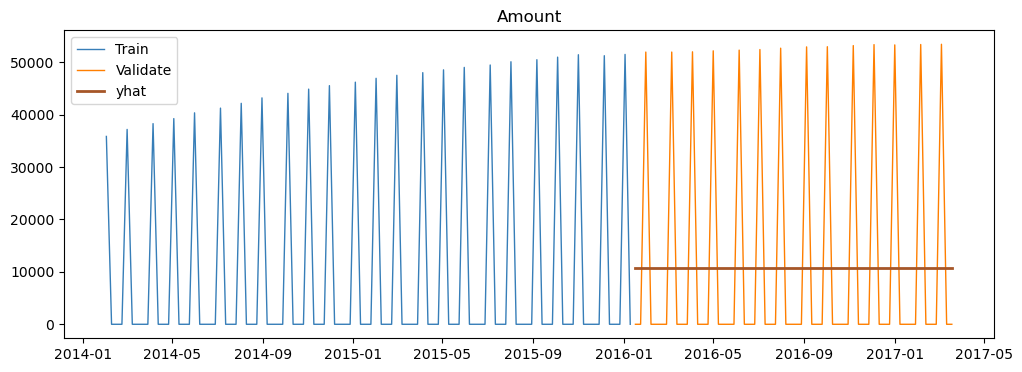

In [14]:
for col in train.columns:
    plot_and_eval(col)

In [15]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,22080.0


# Holt's Linear

In [16]:
col = 'Amount' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [17]:
model = model.fit(optimized=True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [18]:
yhat_sales_total = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [19]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [20]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-17,16826.02
2016-01-24,17750.37
2016-01-31,18665.48
2016-02-07,19571.44
2016-02-14,20468.35


Amount -- RMSE: 37813


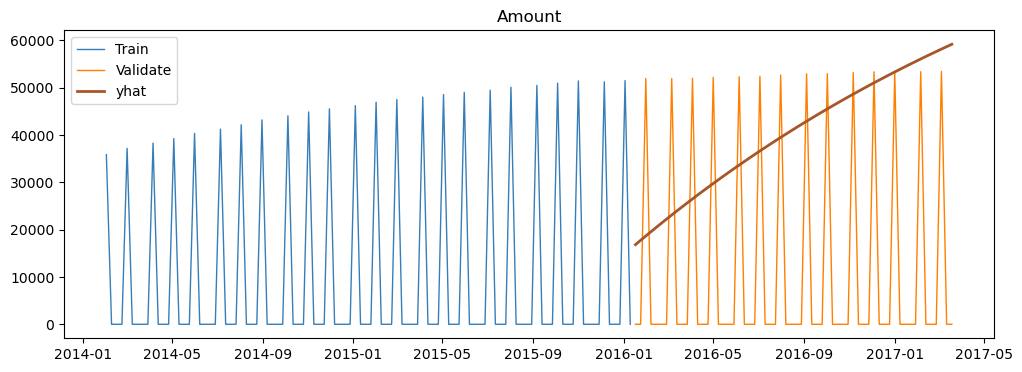

In [21]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [22]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [23]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,simple_average,Amount,22080.0
1,holts_optimized,Amount,37813.0


# Holt's Seasonal

In [24]:
# Models for Amount
hst_amount_fit1 = ExponentialSmoothing(train.Amount, seasonal_periods=30, trend='add', seasonal='add').fit()
#hst_amount_fit2 = ExponentialSmoothing(train.Amount, seasonal_periods=30, trend='add', seasonal='mul').fit()
hst_amount_fit2 = ExponentialSmoothing(train.Amount, seasonal_periods=30, trend='add', seasonal='add', damped=True).fit()
#hst_amount_fit4 = ExponentialSmoothing(train.Amount, seasonal_periods=30, trend='add', seasonal='mul', damped=True).fit()


/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [25]:
results_quantity=pd.DataFrame({'model':['hst_amount_fit1', 'hst_amount_fit2'],
                              'SSE':[hst_amount_fit1.sse, hst_amount_fit2.sse]})
results_quantity

,model,SSE
0,hst_amount_fit1,3.269734e+10
1,hst_amount_fit2,3.266570e+10


In [26]:
yhat_df = pd.DataFrame({'Amount': hst_amount_fit2.forecast(validate.shape[0])
                           },
                          index=validate.index)
yhat_df

,Amount
Month_Invoiced,
2016-01-17,1161.012764
2016-01-24,23526.842004
2016-01-31,25508.976781
2016-02-07,2288.529843
2016-02-14,2203.044815
...,...
2017-02-19,48546.910354
2017-02-26,1614.407470
2017-03-05,1969.795160


Amount -- RMSE: 30908


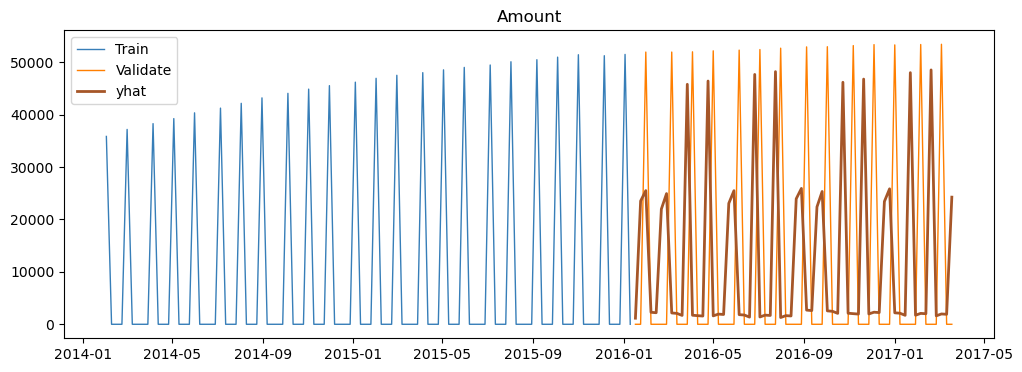

In [27]:
for col in train.columns:
    plot_and_eval(col)

In [28]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [29]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,simple_average,Amount,22080.0
2,holts_seasonal_add_add,Amount,30908.0
1,holts_optimized,Amount,37813.0


# Previous cycle

In [30]:
train = saas_resampled[:'2015']
validate = saas_resampled['2016']
test = saas_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(100, 1)
(52, 1)
(53, 1)


,Amount
Month_Invoiced,
2015-11-29,0.0
2015-12-06,51260.0
2015-12-13,0.0
2015-12-20,0.0
2015-12-27,0.0


In [31]:
train.diff(30)

,Amount
Month_Invoiced,
2014-02-02,NaN
2014-02-09,NaN
2014-02-16,NaN
2014-02-23,NaN
2014-03-02,NaN
...,...
2015-11-29,-48560.0
2015-12-06,51260.0
2015-12-13,0.0


In [32]:
yhat_df = train['2015'] + train.diff(30).mean()
yhat_df

,Amount
Month_Invoiced,
2015-01-04,46630.071429
2015-01-11,420.071429
2015-01-18,420.071429
2015-01-25,420.071429
2015-02-01,47365.071429
2015-02-08,420.071429
2015-02-15,420.071429
2015-02-22,420.071429
2015-03-01,47940.071429


In [33]:
train.diff(30).mean()

Amount    420.071429
dtype: float64

In [34]:
train.loc['2015'].head()

,Amount
Month_Invoiced,
2015-01-04,46210.0
2015-01-11,0.0
2015-01-18,0.0
2015-01-25,0.0
2015-02-01,46945.0


In [35]:
yhat_df.head()

,Amount
Month_Invoiced,
2015-01-04,46630.071429
2015-01-11,420.071429
2015-01-18,420.071429
2015-01-25,420.071429
2015-02-01,47365.071429


In [36]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Amount
Month_Invoiced,
2015-01-04,46630.071429
2016-01-03,51505.000000


In [37]:
yhat_df.index = validate.index

In [38]:
yhat_df

,Amount
Month_Invoiced,
2016-01-03,46630.071429
2016-01-10,420.071429
2016-01-17,420.071429
2016-01-24,420.071429
2016-01-31,47365.071429
2016-02-07,420.071429
2016-02-14,420.071429
2016-02-21,420.071429
2016-02-28,47940.071429


Amount -- RMSE: 17355


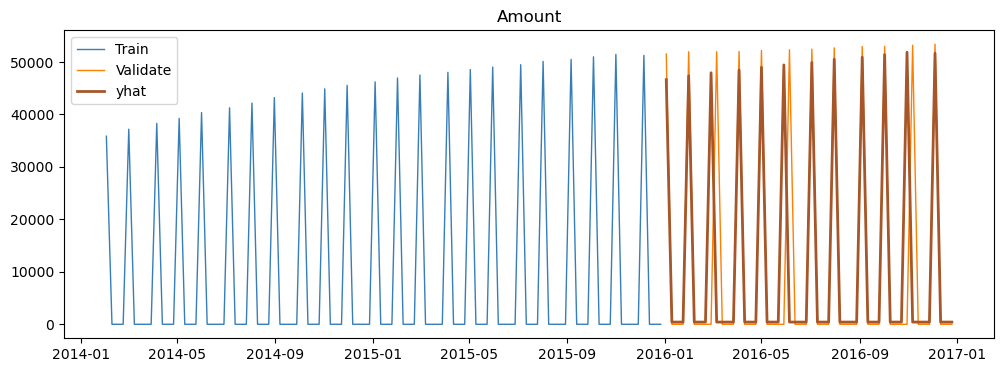

In [39]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [40]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
3,previous_year,Amount,17355.0
0,simple_average,Amount,22080.0
2,holts_seasonal_add_add,Amount,30908.0
1,holts_optimized,Amount,37813.0


In [41]:
amount_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

# find which model that is
eval_df[(eval_df.rmse == amount_total_min_rmse)] 
         

,model_type,target_var,rmse
3,previous_year,Amount,17355.0


# Test

In [42]:
train = saas_resampled[:'2015']
validate = saas_resampled['2016']
test = saas_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(100, 1)
(52, 1)
(53, 1)


,Amount
Month_Invoiced,
2015-11-29,0.0
2015-12-06,51260.0
2015-12-13,0.0
2015-12-20,0.0
2015-12-27,0.0


In [43]:
train.shape, validate.shape, test.shape

((100, 1), (52, 1), (53, 1))

In [44]:
test.diff(30)

,Amount
Month_Invoiced,
2017-01-01,NaN
2017-01-08,NaN
2017-01-15,NaN
2017-01-22,NaN
2017-01-29,NaN
2017-02-05,NaN
2017-02-12,NaN
2017-02-19,NaN
2017-02-26,NaN


In [45]:
yhat_df = test['2017'] + test.diff(30).mean()
yhat_df

,Amount
Month_Invoiced,
2017-01-01,53433.695652
2017-01-08,113.695652
2017-01-15,113.695652
2017-01-22,113.695652
2017-01-29,113.695652
2017-02-05,53508.695652
2017-02-12,113.695652
2017-02-19,113.695652
2017-02-26,113.695652


In [46]:
test.diff(30).mean()

Amount    113.695652
dtype: float64

In [47]:
test.loc['2017'].head()

,Amount
Month_Invoiced,
2017-01-01,53320.0
2017-01-08,0.0
2017-01-15,0.0
2017-01-22,0.0
2017-01-29,0.0


In [55]:
pd.concat([yhat_df.head(1), test.head(1)])

,Amount
Month_Invoiced,
2017-01-01,53433.695652
2017-01-01,53320.000000


In [49]:
yhat_df.index = test.index

In [50]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [51]:
rmse_amount_total = sqrt(mean_squared_error(test['Amount'], 
                                       yhat_df['Amount']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-amount total:  113.69565217391282


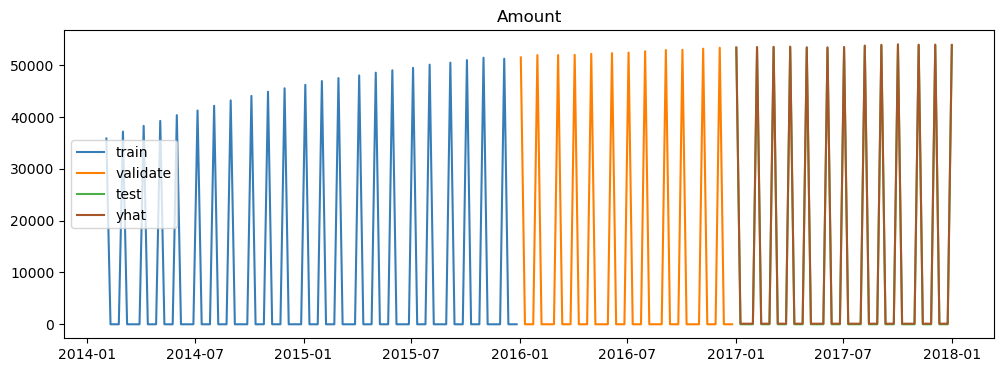

In [52]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-amount total: ', rmse_amount_total)
for col in test.columns:
    final_plot(col)

# Forecasting

In [53]:
yhat_df

,Amount
Month_Invoiced,
2017-01-01,53433.695652
2017-01-08,113.695652
2017-01-15,113.695652
2017-01-22,113.695652
2017-01-29,113.695652
2017-02-05,53508.695652
2017-02-12,113.695652
2017-02-19,113.695652
2017-02-26,113.695652


In [68]:
forecast = test['2017'] + test.diff(30).mean() + 365

#forecast = forecast['2018']
forecast

,Amount
Month_Invoiced,
2017-01-01,53798.695652
2017-01-08,478.695652
2017-01-15,478.695652
2017-01-22,478.695652
2017-01-29,478.695652
2017-02-05,53873.695652
2017-02-12,478.695652
2017-02-19,478.695652
2017-02-26,478.695652


In [69]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

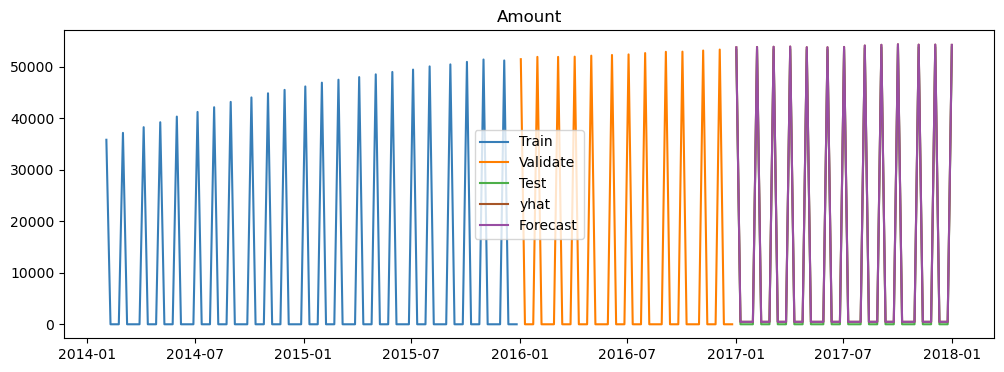

In [70]:
for col in train.columns:
    final_plot(col)